<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/ML_Ensambles_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Random Forest

#Introducción


Un modelo Random Forest está formado por un **conjunto de árboles de decisión individuales**, cada uno entrenado con una muestra ligeramente distinta de los datos de entrenamiento generada mediante **bootstrapping**. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

Muchos métodos predictivos generan modelos globales en los que una única ecuación se aplica a todo el espacio muestral. Cuando el caso de uso implica múltiples predictores, que interaccionan entre ellos de forma compleja y no lineal, es muy difícil encontrar un único modelo global que sea capaz de reflejar la relación entre las variables. Los métodos estadísticos y de machine learning basados en árboles engloban a un conjunto de técnicas supervisadas no paramétricas que consiguen segmentar el espacio de los predictores en regiones simples, dentro de las cuales es más sencillo manejar las interacciones. Es esta característica la que les proporciona gran parte de su potencial.

Los métodos basados en árboles se han convertido en uno de los referentes dentro del ámbito predictivo debido a los buenos resultados que generan en problemas muy diversos. A lo largo de este documento se explora la forma en que se construyen y predicen los modelos Random Forest. Dado que el elemento fundamental de un modelo Random Forest son los árboles de decisión, es fundamental entender cómo funcionan estos últimos.


##Ventajas

- Son capaces de seleccionar predictores de forma automática.

- Pueden aplicarse a problemas de regresión y clasificación.

- Los árboles pueden, en teoría, manejar tanto predictores numéricos como categóricos sin tener que crear variables dummy o one-hot-encoding. En la práctica, esto depende de la implementación del algoritmo que tenga cada librería.

- Al tratarse de métodos no paramétricos, no es necesario que se cumpla ningún tipo de distribución específica.

- Por lo general, requieren mucha menos limpieza y pre procesado de los datos en comparación a otros métodos de aprendizaje estadístico (por ejemplo, no requieren estandarización).

- No se ven muy influenciados por outliers.

- Si para alguna observación, el valor de un predictor no está disponible, a pesar de no poder llegar a ningún nodo terminal, se puede conseguir una predicción empleando todas las observaciones que pertenecen al último nodo alcanzado. La precisión de la predicción se verá reducida pero al menos podrá obtenerse.

- Son muy útiles en la exploración de datos, permiten identificar de forma rápida y eficiente las variables (predictores) más importantes.

- Gracias al Out-of-Bag Error puede estimarse su error de validación sin necesidad de recurrir a estrategias computacionalmente costosas como la validación cruzada. Esto no aplica en el caso de series temporales.

- Tienen buena escalabilidad, pueden aplicarse a conjuntos de datos con un elevado número de observaciones.

##Desventajas

- Al combinar múltiples árboles, se pierde la interpretabilidad que tienen los modelos basados en un único árbol.

- Cuando tratan con predictores continuos, pierden parte de su información al categorizarlas en el momento de la división de los nodos.

- Tal y como se describe más adelante, la creación de las ramificaciones de los árboles se consigue mediante el algoritmo de recursive binary splitting. Este algoritmo identifica y evalúa las posibles divisiones de cada predictor acorde a una determinada medida (RSS, Gini, entropía…). Los predictores continuos o predictores cualitativos con muchos niveles tienen mayor probabilidad de contener, solo por azar, algún punto de corte óptimo, por lo que suelen verse favorecidos en la creación de los árboles.

- No son capaces de extrapolar fuera del rango de los predictores observado en los datos de entrenamiento.


#Arboles de decisión y Random Forest en Python

Existen tres implementaciones principales de árboles de decisión y Random Forest en Python: scikit-learn, skranger y H2O. Aunque todas están muy optimizadas y se utilizan de forma similar, tienen una diferencia en su implementación que puede generar resultados distintos. En scikit-learn es necesario hacer one-hot-encoding de los predictores categóricos, mientras que en H2O no. Esto tiene impacto directo en la estructura de los árboles generados y, en consecuencia, en los resultados predictivos del modelo y en la importancia calculada para los predictores (ver detalles más adelante).







# Random Forest


Un modelo Random Forest está formado por un conjunto (ensemble) de árboles de decisión individuales, cada uno entrenado con una muestra aleatoria extraída de los datos de entrenamiento originales mediante bootstrapping. Esto implica que cada árbol se entrena con unos datos ligeramente distintos. En cada árbol individual, las observaciones se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal, tal como un árbol de decisión tradicional. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

Para entender cómo funcionan los modelos Random Forest es necesario conocer primero los conceptos de ensemble y bagging.


##Métodos de ensemble


Todos los modelos de aprendizaje estadístico y machine learning sufren el problema de equilibrio entre bias y varianza.

El término bias (sesgo) hace referencia a cuánto se alejan en promedio las predicciones de un modelo respecto a los valores reales. Refleja cómo de capaz es el modelo de aprender la relación real que existe entre los predictores y la variable respuesta. Por ejemplo, si la relación sigue un patrón no lineal, por muchos datos de los que se disponga, un modelo de regresión lineal no podrá modelar correctamente la relación, por lo que tendrá un bias alto.

El término varianza hace referencia a cuánto cambia el modelo dependiendo de los datos utilizados en su entrenamiento. Idealmente, un modelo no debería modificarse demasiado por pequeñas variaciones en los datos de entrenamiento, si esto ocurre, es porque el modelo está memorizando los datos en lugar de aprender la verdadera relación entre los predictores y la variable respuesta. Por ejemplo, un modelo de árbol con muchos nodos, suele variar su estructura con que apenas cambien unos pocos datos de entrenamiento, por lo tanto tiene mucha varianza.

A medida que aumenta la complejidad de un modelo, este dispone de mayor flexibilidad para adaptarse a las observaciones, reduciendo así el bias y mejorando su capacidad predictiva. Sin embargo, alcanzado un determinado grado de flexibilidad, aparece el problema de overfitting, el modelo se ajusta tanto a los datos de entrenamiento que es incapaz de predecir correctamente nuevas observaciones. El mejor modelo es aquel que consigue un equilibro óptimo entre bias y varianza.

¿Cómo se controlan el bias y varianza en los modelos basados en árboles? Por lo general, los árboles pequeños (pocas ramificaciones) tienen poca varianza pero no consiguen representar bien la relación entre las variables, es decir, tienen bias alto. En contraposición, los árboles grandes se ajustan mucho a los datos de entrenamiento, por lo que tienen muy poco bias pero mucha varianza. Una forma de solucionar este problema son los métodos de ensemble.

Los métodos de ensemble combinan múltiples modelos en uno nuevo con el objetivo de lograr un equilibro entre bias y varianza, consiguiendo así mejores predicciones que cualquiera de los modelos individuales originales. Dos de los tipos de ensemble más utilizados son:

- Bagging: Se ajustan múltiples modelos, cada uno con un subconjunto distinto de los datos de entrenamiento. Para predecir, todos los modelos que forman el agregado participan aportando su predicción. Como valor final, se toma la media de todas las predicciones (variables continuas) o la clase más frecuente (variables categóricas). Los modelos Random Forest están dentro de esta categoría.

- Boosting: Se ajustan secuencialmente múltiples modelos sencillos, llamados weak learners, de forma que cada modelo aprende de los errores del anterior. Como valor final, al igual que en bagging, se toma la media de todas las predicciones (variables continuas) o la clase más frecuente (variables cualitativas). Tres de los métodos de boosting más empleados son AdaBoost, Gradient Boosting y Stochastic Gradient Boosting.

Aunque el objetivo final es el mismo, lograr un balance óptimo entre bias y varianza, existen dos diferencias importantes:

- Forma en que consiguen reducir el error total. El error total de un modelo puede descomponerse como $bias+varianza+ϵ$. En bagging, se emplean modelos con muy poco bias pero mucha varianza, agregándolos se consigue reducir la varianza sin apenas inflar el bias. En boosting, se emplean modelos con muy poca varianza pero mucho bias, ajustando secuencialmente los modelos se reduce el bias. Por lo tanto, cada una de las estrategias reduce una parte del error total.

- Forma en que se introducen variaciones en los modelos que forman el ensemble. En bagging, cada modelo es distinto del resto porque cada uno se entrena con una muestra distinta obtenida mediante bootstrapping. En boosting, los modelos se ajustan secuencialmente y la importancia (peso) de las observaciones va cambiando en cada iteración, dando lugar a diferentes ajustes.

La clave para que los métodos de ensemble consigan mejores resultados que cualquiera de sus modelos individuales es que los modelos que los forman sean lo más diversos posibles (sus errores no estén correlacionados). Una analogía que refleja este concepto es la siguiente: supóngase un juego como el trivia en el que los equipos tienen que acertar preguntas sobre temáticas diversas. Un equipo formado por muchos jugadores, cada uno experto en un tema distinto, tendrá más posibilidades de ganar que un equipo formado por jugadores expertos en un único tema o por un único jugador que sepa un poco de todos los temas.

A continuación, se describe con más detalle la estrategia de bagging, sobre la que se fundamenta el modelo Random Forest.


##Bagging


El término bagging es el diminutivo de bootstrap aggregation, y hace referencia al empleo del muestreo repetido con reposición bootstrapping con el fin de reducir la varianza de algunos modelos de aprendizaje estadístico, entre ellos los basados en árboles.

Dadas $n$ muestras de observaciones independientes $Z_1 , ...,  Z_n$, cada una con varianza  σ^2 , la varianza de la media de las observaciones  $\bar{Z}$  es $σ^2/n$ . En otras palabras, promediando un conjunto de observaciones se reduce la varianza. Basándose en esta idea, una forma de reducir la varianza y aumentar la precisión de un método predictivo es obtener múltiples muestras de la población, ajustar un modelo distinto con cada una de ellas, y hacer la media (la moda en el caso de variables cualitativas) de las predicciones resultantes. Como en la práctica no se suele tener acceso a múltiples muestras, se puede simular el proceso recurriendo a bootstrapping), generando así pseudo-muestras con los que ajustar diferentes modelos y después agregarlos. A este proceso se le conoce como bagging y es aplicable a una gran variedad de métodos de regresión.

En el caso particular de los árboles de decisión, dada su naturaleza de bajo bias y alta varianza, bagging ha demostrado tener muy buenos resultados. La forma de aplicarlo es:

1. Generar $B$ pseudo-training sets mediante bootstrapping a partir de la muestra de entrenamiento original.

2. Entrenar un árbol con cada una de las $B$ muestras del paso 1. Cada árbol se crea sin apenas restricciones y no se somete a pruning, por lo que tiene varianza alta pero poco bias. En la mayoría de casos, la única regla de parada es el número mínimo de observaciones que deben tener los nodos terminales. El valor óptimo de este hiperparámetro puede obtenerse comparando el out of bag error o por validación cruzada.

3. Para cada nueva observación, obtener la predicción de cada uno de los $B$ árboles. El valor final de la predicción se obtiene como la media de las $B$ predicciones en el caso de variables cuantitativas y como la clase predicha más frecuente (moda) para variables cualitativas.

En el proceso de bagging, el número de árboles creados no es un hiperparámetro crítico en cuanto a que, por mucho que se incremente el número, no se aumenta el riesgo de overfitting. Alcanzado un determinado número de árboles, la reducción de test error se estabiliza. A pesar de ello, cada árbol ocupa memoria, por lo que no conviene almacenar más de los necesarios.

##Entrenamiento de Random Forest

El algoritmo de Random Forest es una modificación del proceso de bagging que consigue mejorar los resultados gracias a que los árboles generados en el proceso son menos correlacionados.

Recordando el apartado anterior, los beneficios de bagging se basan en el hecho de que, promediando un conjunto de modelos, se consigue reducir la varianza. Esto es cierto, siempre y cuando los modelos agregados no estén correlacionados. Si la correlación es alta, la reducción de varianza que se puede lograr es pequeña.

Supóngase un set de datos en el que hay un predictor muy influyente, junto con otros moderadamente influyentes. En este escenario, todos o casi todos los árboles creados en el proceso de bagging estarán dominados por el mismo predictor y serán muy parecidos entre ellos. Como consecuencia de la alta correlación entre los árboles, el proceso de bagging apenas conseguirá disminuir la varianza y, por lo tanto, tampoco mejorar el modelo. Random forest evita este problema haciendo una selección aleatoria de $m$ predictores antes de evaluar cada división. De esta forma, un promedio de $(p−m)/p$ divisiones no contemplarán el predictor influyente, permitiendo que otros predictores puedan ser seleccionados. Añadiendo este paso extra se consigue decorrelacionar los árboles todavía más, con lo que su agregación consigue una mayor reducción de la varianza.

Los métodos de random forest y bagging siguen el mismo algoritmo con la única diferencia de que, en random forest, antes de cada división, se seleccionan aleatoriamente $m$ predictores. La diferencia en el resultado dependerá del valor $m$ escogido. Si $m=p$ los resultados de random forest y bagging son equivalentes. Algunas recomendaciones son:

- La raíz cuadrada del número total de predictores para problemas de clasificación.  $m≈\sqrt{p}$
- Un tercio del número de predictores para problemas de regresión. $m≈p/3$
- Si los predictores están muy correlacionados, valores pequeños de  m  consiguen mejores resultados.

Sin embargo, la mejor forma para encontrar el valor óptimo de  m  es evaluar el out-of-bag-error o recurrir a validación cruzada.

Al igual que ocurre con bagging, random forest no sufre problemas de overfit por aumentar el número de árboles creados en el proceso. Alcanzado un determinado número, la reducción del error de test se estabiliza.


##Predicción de Random Forest


La predicción de un modelo Random Forest es la media de las predicciones de todos los árboles que lo forman.

Supóngase que se dispone de 10 observaciones, cada una con un valor de variable respuesta  Y  y unos predictores  X .
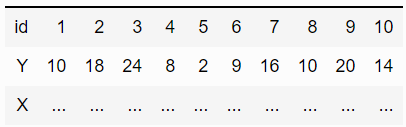

La siguiente imagen muestra cómo sería la predicción del modelo para una nueva observación. En cada árbol, el camino hasta llegar al nodo final está resaltado. En cada nodo terminal se detalla el índice de las observaciones de entrenamiento que forman parte.


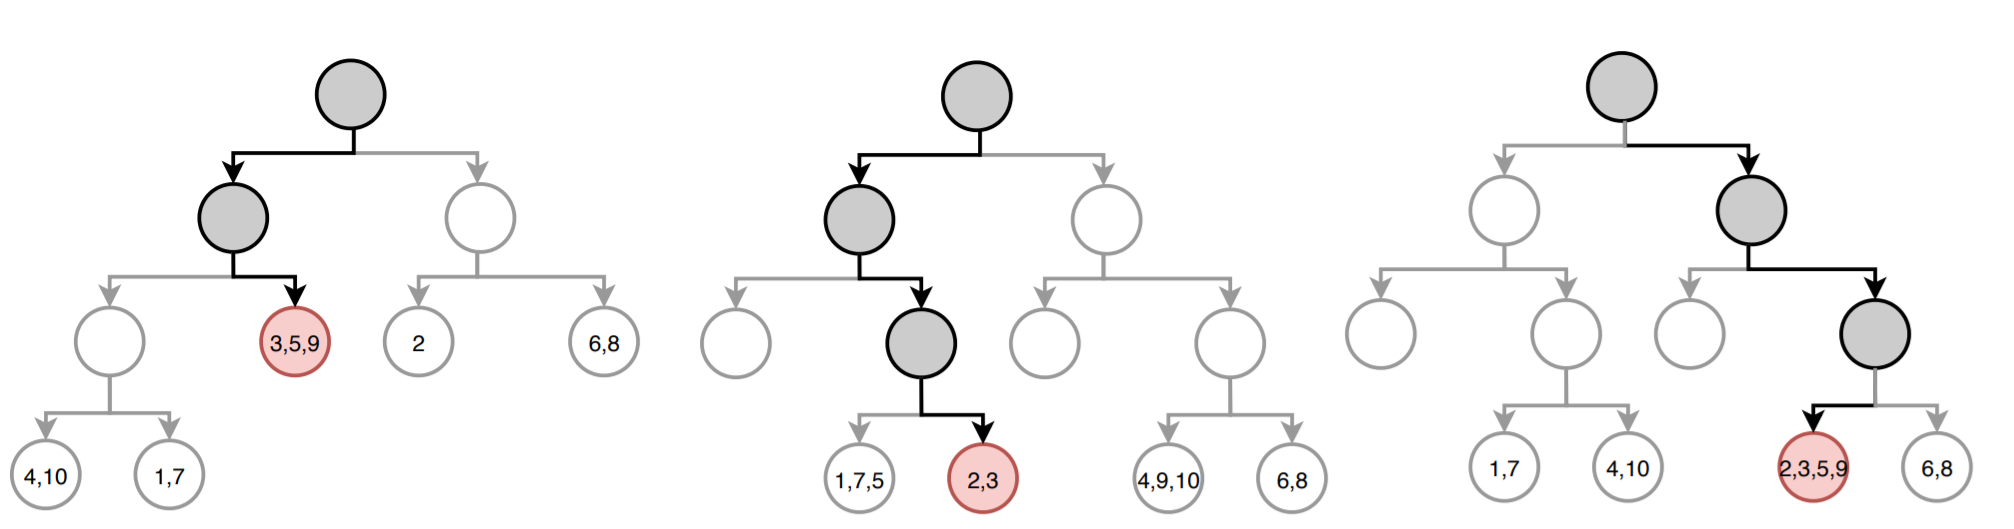

Predicción con random forest: en cada árbol, el camino hasta llegar al nodo final está resaltado. En cada nodo terminal se detalla el índice de las observaciones de entrenamiento que forman parte de él.

El valor predicho por cada árbol es la media de la variable respuesta $Y$ en el nodo terminal. Acorde a la imagen, las predicciones de cada uno de los tres árboles (de izquierda a derecha) es:

$$\hat{y}_{arbol_1}=\frac{24+2+20}3=15.33333 $$

$$\hat{y}_{arbol_2}=\frac{18+24}2=21 $$

$$\hat{y}_{arbol_3}=\frac{18+24+2+20}4=16 $$

La predicción final del modelo es la media de todas las predicciones individuales:

$$\hat{μ}=\frac{15.33333+21+16}3=17.4 $$



#Out-of-Bag Error


Dada la naturaleza del proceso de bagging, resulta posible estimar el error de test sin necesidad de recurrir a métodos de validación cruzada (cross-validation). El hecho de que los árboles se ajusten empleando muestras generadas por bootstrapping conlleva que, en promedio, cada ajuste use solo aproximadamente dos tercios de las observaciones originales. Al tercio restante se le llama out-of-bag (OOB).

Si para cada árbol ajustado en el proceso de bagging se registran las observaciones empleadas, se puede predecir la respuesta de la observación $i$ haciendo uso de aquellos árboles en los que esa observación ha sido excluida y promediándolos (o mediante voting en el caso de los árboles de clasificación). Siguiendo este proceso, se pueden obtener las predicciones para las $n$ observaciones y con ellas calcular el OOB-mean square error (para regresión) o el OOB-classification error (para árboles de clasificación). Como la variable respuesta de cada observación se predice empleando únicamente los árboles en cuyo ajuste no participó dicha observación, el OOB-error sirve como estimación del error de test. De hecho, si el número de árboles es suficientemente alto, el OOB-error es prácticamente equivalente al leave-one-out cross-validation error.

Esta es una ventaja añadida de los métodos de bagging, y por lo tanto de Random Forest ya que evita tener que recurrir al proceso de validación cruzada (computacionalmente costoso) para la optimización de los hiperparámetros.

Dos limitaciones en el uso Out-of-Bag Error:

- El Out-of-Bag Error no es adecuado cuando las observaciones tienen una relación temporal (series temporales). Como la selección de las observaciones que participan en cada entrenamiento es aleatoria, no respetan el orden temporal y se estaría introduciendo información a futuro.

- El preprocesado de los datos de entrenamiento se hace de forma conjunta, por lo que las observaciones out-of-bag pueden sufrir data leakage. De ser así, las estimaciones del OOB-error son demasiado optimistas.

- En un muestreo por bootstrapping, si el tamaño de los datos de entrenamiento es $n$, cada observación tiene una probabilidad de ser elegida de $1/n$. Por lo tanto, la probabilidad de no ser elegida en todo el proceso es de $(1−1/n)^n$ , lo que converge en  1/ϵ , que es aproximadamente un tercio.


##Importancia de los predictores


Si bien es cierto que el proceso de bagging (Random Forest) consigue mejorar la capacidad predictiva en comparación a los modelos basados en un único árbol, esto tiene un coste asociado, la interpretabilidad del modelo se reduce. Al tratarse de una combinación de múltiples árboles, no es posible obtener una representación gráfica sencilla del modelo y no es inmediato identificar de forma visual que predictores son más importantes. Sin embargo, se han desarrollado nuevas estrategias para cuantificar la importancia de los predictores que hacen de los modelos de bagging (Random Forest) una herramienta muy potente, no solo para predecir, sino también para el análisis exploratorio. Dos de estas medidas son: importancia por permutación e impureza de nodos.


##Importancia por permutación

Identifica la influencia que tiene cada predictor sobre una determinada métrica de evaluación del modelo (estimada por out-of-bag error o validación cruzada). El valor asociado con cada predictor se obtiene de la siguiente forma:

1. Crear el conjunto de árboles que forman el modelo.

2. Calcular una determinada métrica de error (mse, classification error, ...). Este es el valor de referencia ($error_0$).

3. Para cada predictor $j$:

- 3.1. Permutar en todos los árboles del modelo los valores del predictor  $j$ manteniendo el resto constante.

- 3.2. Recalcular la métrica tras la permutación, llámese ($error_j$).

- 3.3. Calcular el incremento en la métrica debido a la permutación del predictor $j$.

$$Incremento_j=(error_j−error_0)/error0∗100 $$

Si el predictor permutado estaba contribuyendo al modelo, es de esperar que el modelo aumente su error, ya que se pierde la información que proporcionaba esa variable. El porcentaje en que se incrementa el error debido a la permutación del predictor $j$ puede interpretarse como la influencia que tiene $j$ sobre el modelo. Algo que suele llevar a confusiones es el hecho de que este incremento puede resultar negativo. Si la variable no contribuye al modelo, es posible que, al reorganizarla aleatoriamente, solo por azar, se consiga mejorar ligeramente el modelo, por lo que ($error_j−error_0$)  es negativo. A modo general, se puede considerar que estas variables tiene una importancia próxima a cero.

Aunque esta estrategia suele ser la más recomendada, cabe tomar algunas precauciones en su interpretación. Lo que cuantifican es la influencia que tienen los predictores sobre el modelo, no su relación con la variable respuesta. ¿Por qué es esto tan importante? Supóngase un escenario en el que se emplea esta estrategia con la finalidad de identificar qué predictores están relacionados con el peso de una persona, y que dos de los predictores son: el índice de masa corporal (IMC) y la altura. Como IMC y altura están muy correlacionados entre sí (la información que aportan es redundante), cuando se permute uno de ellos, el impacto en el modelo será mínimo, ya que el otro aporta la misma información. Como resultado, estos predictores aparecerán como poco influyentes aun cuando realmente están muy relacionados con la variable respuesta. Una forma de evitar problemas de este tipo es, siempre que se excluyan predictores de un modelo, comprobar el impacto que tiene en su capacidad predictiva.


##Incremento de la pureza de nodos

Cuantifica el incremento total en la pureza de los nodos debido a divisiones en las que participa el predictor (promedio de todos los árboles). La forma de calcularlo es la siguiente: en cada división de los árboles, se registra el descenso conseguido en la medida empleada como criterio de división (índice Gini, mse entropía, ...). Para cada uno de los predictores, se calcula el descenso medio conseguido en el conjunto de árboles que forman el ensemble. Cuanto mayor sea este valor medio, mayor la contribución del predictor en el modelo.


#Ejemplo regresión


##Librerías


Las librerías utilizadas en este ejemplo son:

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


#Datos

El set de datos `Boston` disponible en la librería scikitlearn contiene precios de viviendas de la ciudad de Boston, así como información socio-económica del barrio en el que se encuentran. Se pretende ajustar un modelo de regresión que permita predecir el precio medio de una vivienda (MEDV) en función de las variables disponibles.

Number of Instances: 506

Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

Attribute Information (in order):

- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per \$10,000
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: % lower status of the population
- MEDV: Median value of owner-occupied homes in $ 1000's

Missing Attribute Values: None

Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset. https://archive.ics.uci.edu/ml/machine-learning-databases/housing/


In [ ]:
# Se unen todos los datos (predictores y variable respuesta en un único dataframe)
boston = load_boston(return_X_y=False)
datos = np.column_stack((boston.data, boston.target))
datos = pd.DataFrame(datos,columns = np.append(boston.feature_names, "MEDV"))
datos.head(3)

In [ ]:
datos.info()

#Ajuste del modelo

Se ajusta un modelo empleando como variable respuesta MEDV y como predictores todas las otras variables disponibles.

La clase `RandomForestRegressor` del módulo `sklearn.ensemble` permite entrenar modelos random forest para problemas de regresión. Los parámetros e hiperparámetros empleados por defecto son:

n_estimators=100
criterion='mse'
max_depth=None
min_samples_split=2
min_samples_leaf=1
min_weight_fraction_leaf=0.0
max_features='auto'
max_leaf_nodes=None
min_impurity_decrease=0.0
min_impurity_split=None
bootstrap=True
oob_score=False
n_jobs=None
random_state=None
verbose=0
warm_start=False
ccp_alpha=0.0
max_samples=None

 entre todos ellos, destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

- n_estimators: número de árboles incluidos en el modelo.

- max_depth: profundidad máxima que pueden alcanzar los árboles.

- min_samples_split: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- min_samples_leaf: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- max_leaf_nodes: número máximo de nodos terminales que pueden tener los árboles.

- max_features: número de predictores considerados a en cada división. Puede ser:

  - Un valor entero
  - Una fracción del total de predictores.
  - “auto”, utiliza todos los predictores.
  - “sqrt”, raiz cuadrada del número total de predictores.
  - “log2”, log2 del número total de predictores.
  - None, utiliza todos los predictores.
  - oob_score: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

- n_jobs: número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

- random_state: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.


Como en todo estudio predictivo, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer esta evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.

In [ ]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

# Predicción y evaluación del modelo


Una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test.

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Optimización de hiperparámetros


El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. En la implementación de `RandomForestRegressor`, la métrica devuelta como oob_score es el  $R^2$ , si se desea otra, se tiene que recurrir al método `oob_decision_function_()` para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: [Grid search de modelos Random Forest con out-of-bag error y early stopping](https://www.cienciadedatos.net/documentos/py36-grid-search-random-forest-out-of-bag-error-early-stopping.html).

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

## Número de árboles


En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida de recursos computacionales.

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Ambas métricas indican que, a partir de entre 20 y 60 árboles, el error de validación del modelo se estabiliza.

## Max features
El valor de máx_features es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:

    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Acorde a las dos métricas utilizadas, el valor óptimo de max_features está entre 5 y 9.


# Grid search


Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. Puede encontrarse más información sobre las estrategias de búsqueda en Machine learning con Python y Scikit-learn.

# Grid Search basado en out-of-bag error

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [50, 100, 150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train, y_train)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

In [ ]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params
    )

    modelo.fit(X, y)

    if verbose:
        print(f"Modelo: {params} \u2713")

    return{'params': params, 'oob_r2': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train, y_train, RandomForestRegressor(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

In [ ]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

## Grid Search basado en validación cruzada

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el `GridSearchCV()` se indica `refit=True`, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

Tras optimizar los hiperparámetros, se consigue reducir el error rmse del modelo de 4.35 a 3.74. Las predicciones del modelo final se alejan en promedio 3.74 unidades (3740 dólares) del valor real.


# Importancia de predictores


## Importancia por pureza de nodos

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "MEDV").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

## Importancia por permutación

In [ ]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

# Ejemplo clasificación


# Librerías


Las librerías utilizadas en este documento son:

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# Datos


El set de datos Carseats, original del paquete de R ISLR y accesible en Python a través de `statsmodels.datasets.get_rdataset`, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.

Nota: listado de todos los set de datos disponibles en [Rdatasets](https://vincentarelbundock.github.io/Rdatasets/articles/data.html)

In [ ]:
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
print(carseats.__doc__)

In [ ]:
datos.head(3)

Como `Sales` es una variable continua y el objetivo del estudio es clasificar las tiendas según si venden mucho o poco, se crea una nueva variable binaria (0, 1) llamada `ventas_altas`.

In [ ]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

# Ajuste del modelo y optimización de hiperparámetros


Se ajusta un árbol de clasificación empleando como variable respuesta `ventas_altas` y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros `max_depth=5 `y `criterion='gini'`, el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.

A diferencia del ejemplo anterior, en estos datos hay variables categóricas por lo que, antes de entrenar el modelo, es necesario aplicar one-hot-encoding. Puede encontrarse una descripción más detallada de este proceso en Machine learning con Python y Scikit-learn.

In [ ]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

El resultado devuelto por `ColumnTransformer` es un `numpy array`, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato `dataframe`. Por defecto, `OneHotEncoder` ordena las nuevas columnas de izquierda a derecha por orden alfabético.

In [ ]:
# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

Si bien `RandomForestClassifier` tiene valores por defecto para sus hiperparámetros, no se puede saber de antemano si estos son los más adecuados, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. En la implementación de `RandomForestClassifier`, la métrica devuelta como oob_score es el accuracy, si se desea otra, se tiene que recurrir al método `oob_decision_function_()` para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping. Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. Puede encontrarse más información sobre las estrategias de búsqueda en Machine learning con Python y Scikit-learn.

# Grid Search basado en out-of-bag score

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:

    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train_prep, y_train)

    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

In [ ]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params
    )

    modelo.fit(X, y)

    if verbose:
        print(f"Modelo: {params} \u2713")

    return{'params': params, 'oob_accuracy': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train_prep, y_train, RandomForestClassifier(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(4)

In [ ]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print("--------------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_accuracy'], "accuracy")

# Grid Search basado en validación cruzada

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

In [ ]:
modelo_final = grid.best_estimator_

# Predicción y evaluación del modelo


Por último, se evalúa la capacidad predictiva del modelo final empleando el conjunto de test.

In [ ]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test_prep)
predicciones[:10]

In [ ]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

In [ ]:
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

Tras optimizar los hiperparámetros, se consigue un porcentaje de acierto del 78%.

# Predicción de probabilidades


La mayoría de implementaciones de Random Forest, entre ellas la de scikit-learn, permiten predecir probabilidades cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.

En el ejemplo anterior, al aplicar `.predict()` se devuelve  1  (ventas elevadas) o  0  (ventas bajas) para cada observación de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación. Con `.predict_proba()`, en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases.

In [ ]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo_final.predict_proba(X = X_test_prep)
predicciones[:5, :]

El resultado de `.predict_proba()` es un array con una fila por observación y tantas columnas como clases tenga la variable respuesta. El valor de la primera columna se corresponde con la probabilidad, acorde al modelo, de que la observación pertenezca a la clase 0, y así sucesivamente. El valor de probabilidad mostrado para cada predicción se corresponde con la fracción de observaciones de cada clase en los nodos terminales a los que ha llegado la observación predicha en el conjunto de los árboles.

Por defecto, `.predict()` asigna cada nueva observación a la clase con mayor probabilidad (en caso de empate se asigna de forma aleatoria). Sin embargo, este no tiene por qué ser el comportamiento deseado en todos los casos.

In [ ]:
# Clasificación empleando la clase de mayor probabilidad
# ==============================================================================
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

Supóngase el siguiente escenario: la campaña de navidad se aproxima y los propietarios de la cadena quieren duplicar el stock de artículos en aquellas tiendas de las que se preve que tengan ventas elevadas. Como el transporte de este material hasta las tiendas supone un coste elevado, el director quiere limitar esta estrategia únicamente a tiendas para las que se tenga mucha seguridad de que van conseguir muchas ventas.

Si se dispone de las probabilidades, se puede establecer un punto de corte concreto, por ejemplo, considerando únicamente como clase  1  (ventas altas) aquellas tiendas cuya predicción para esta clase sea superior al 0.9 (90%). De esta forma, la clasificación final se ajusta mejor a las necesidades del caso de uso.

In [ ]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ==============================================================================
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.9, 1, 0)
df_predicciones.iloc[4:10, :]

# ¿Hasta que punto se debe de confiar en estas probabilidades?

Es muy importante tener en cuenta la diferencia entre la "visión" que tiene el modelo del mundo y el mundo real. Todo lo que sabe un modelo sobre el mundo real es lo que ha podido aprender de los datos de entrenamiento y, por lo tanto, tiene una "visión" limitada. Por ejemplo, supóngase que, en los datos de entrenamiento, todas las tiendas que están en zona urbana Urban='Yes' tienen ventas altas independientemente del valor que tomen el resto de predictores. Cuando el modelo trate de predecir una nueva observación, si esta está en zona urbana, clasificará a la tienda como ventas elevadas con un 100% de seguridad. Sin embargo, esto no significa que sea inequivocamente cierto, podría haber tiendas en zonas úrbanas que no tienen ventas elevadas pero, al no estar presentes en los datos de entrenamiento, el modelo no contempla esta posibilidad.

Teniendo en cuenta todo esto, hay que considerar las probabilidades generadas por el modelo como la seguridad que tiene este, desde su visión limitada, al realizar las predicciones. Puede encontrase más información sobre cómo sacar máximo partido de las probabilidades predichas por un modelo en Calibrar modelos de machine learning .

# Importancia de predictores


## Importancia por pureza de nodos

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train_prep.columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

## Importancia por permutación

In [ ]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train_prep,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train_prep.columns
df_importancia.sort_values('importances_mean', ascending=False)

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

Ambas estrategias identifican `Urban`, `Income` y `ShelveLoc` como los predictores más influyentes, acorde a los datos de entrenamiento.

# Extrapolación con modelos Random Forest


Una límitación importante de los árboles de regresióna, y por lo tanto de Random Forest es que no extrapolan fuera del rango de entrenamiento. Cuando se aplica el modelo a una nueva observación, cuyo valor o valores de los predictores son superiores o inferiores a los observados en el entrenamiento, la predicción siempre es la media del nodo más cercano, independientemente de cuanto se aleje el valor. Vease el siguiente ejemplo en el que se entrenan dos modelos, un modelo lineal y un arbol de regresión, y luego se predicen valores de  $X$  fuera del rango de entrenamiento.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# Datos simulados
# ==============================================================================
X = np.linspace(0, 150, 100)
y = (X + 100) + np.random.normal(loc=0.0, scale=5.0, size=X.shape)
X_train = X[(X>=50) & (X<100)]
y_train = y[(X>=50) & (X<100)]
X_test_inf = X[X < 50]
y_test_inf = y[X < 50]
X_test_sup = X[X >= 100]
y_test_sup = y[X >= 100]

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X_train, y_train, c='black', linestyle='dashed', label = "Datos train")
ax.axvspan(50, 100, color='gray', alpha=0.2, lw=0)
ax.plot(X_test_inf, y_test_inf, c='blue', linestyle='dashed', label = "Datos test")
ax.plot(X_test_sup, y_test_sup, c='blue', linestyle='dashed')
ax.set_title("Datos de entrenamiento y test")
plt.legend();

In [ ]:
# Modelo lineal
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train.reshape(-1, 1), y_train)

# Modelo random forest
modelo_rf = RandomForestRegressor()
modelo_rf.fit(X_train.reshape(-1, 1), y_train)

# Predicciones
prediccion_lineal = modelo_lineal.predict(X.reshape(-1, 1))
prediccion_rf  = modelo_rf.predict(X.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X_train, y_train, c='black', linestyle='dashed', label = "Datos train")
ax.axvspan(50, 100, color='gray', alpha=0.2, lw=0)
ax.plot(X_test_inf, y_test_inf, c='blue', linestyle='dashed', label = "Datos test")
ax.plot(X_test_sup, y_test_sup, c='blue', linestyle='dashed')
ax.plot(X, prediccion_lineal, c='firebrick',
        label = "Prediccion modelo lineal")
ax.plot(X, prediccion_rf, c='orange',
        label = "Prediccion modelo rf")
ax.set_title("Extrapolación de un modelo lineal y un modelo de random forest")
plt.legend();


La gráfica muestra que, con el modelo Random Forest, el valor predicho fuera del rango de entrenamiento, es el mismo independientemente de cuanto se aleje X. Una estrategia que permite que los modelos basados en árboles extrapolen es ajustar un modelo lineal en cada nodo terminal, pero esto no está disponible en Scikit-learn.


# Variables dummy (one-hot-encoding) en modelos Random Forest


Los modelos basados en árboles de decisión, entre ellos Random Forest, son capaces de utilizar predictores categóricos en su forma natural sin necesidad de convertirlos en variables dummy mediante one-hot-encoding. Sin embargo, en la práctica, depende de la implementación que tenga la librería o software utilizado. Esto tiene impacto directo en la estructura de los árboles generados y, en consecuencia, en los resultados predictivos del modelo y en la importancia calculada para los predictores.

El libro Feature Engineering and Selection A Practical Approach for Predictive Models By Max Kuhn, Kjell Johnson, los autores realizan un experimento en el que se comparan modelos entrenados con y sin one-hot-encoding en 5 sets de datos distintos, los resultados muestran que:

- No hay una diferencia clara en términos de capacidad predictiva de los modelos. Solo en el caso de stocastic gradient boosting se apecian ligeras diferencias en contra de aplicar one-hot-encoding.

- El entrenamiento de los modelos tarda en promedio 2.5 veces más cuando se aplica one-hot-encoding. Esto es debido al aumento de dimensionalidad al crear las nuevas variables dummy, obligando a que el algoritmo tenga que analizar muchos más puntos de división.

En base a los resultados obtenidos, los autores recomiendan no aplicar one-hot-encoding. Solo si los resultados son buenos, probar entonces si se mejoran al crear las variables dummy.

Otra comparación detallada puede encontrarse en Are categorical variables getting lost in your random forests? By Nick Dingwall, Chris Potts, donde los resultados muestran que:

- Al convertir una variable categórica en múltiples variables dummy su importancia queda diluida, dificultando que el modelo pueda aprender de ella y perdiendo así capacidad predictiva. Este efecto es mayor cuantos más niveles tiene la variable original.

- Al diluir la importancia de los predictores categóricos, estos tienen menos probabilidad de ser seleccionada por el modelo, lo que desvirtúa las métricas que miden la importancia de los predictores.

Por el momento, en scikit-learn es necesario hacer one-hot-encoding para convertir las variables categóricas en variables dummy. La implementación de H2O sí permite utilizar directamente variables categóricas.


# Extremely randomized trees


El algoritmo extremely randomized trees lleva la decorrelación de los árboles un paso más allá que random forest. Al igual que en random forest, en cada división de los nodos, solo se evalúa un subconjunto aleatorio de los predictores disponibles. Además de esto, en extremely randomized trees, dentro de cada predictor seleccionado solo se evalúa un subconjunto aleatorio de los posibles puntos de corte. En determinados escenarios, este método consigue reducir un poco más la varianza mejorando la capacidad predictiva del modelo.

Puede encontrase este algoritmo en la case ExtraTrees de scikit-learn o en H2ORandomForestEstimator de H2O (indicando el argumento histogram_type="Random").


# Comparación Random Forest y Gradient Boosting Trees


Random Forest se compara con frecuencia con otro algoritmo basado en árboles, Gradient Boosting Trees. Ambos métodos son muy potentes y la superioridad de uno u otro depende del problema al que se apliquen. Algunos aspectos a tener en cuenta son:

- Gracias al out-of-bag error, el método de Random Forest no necesita recurrir a validación cruzada para la optimización de sus hiperparámetros. Esto puede ser una ventaja muy importante cuando los requerimientos computacionales son limitantes. Esta característica también está presente en Stochastic Gradient Boosting pero no en AdaBoost y Gradient Boosting.

- Random forest tiene menos hiperparámetros, lo que hace más sencillo su correcta implementación.

- Si existe una proporción alta de predictores irrelevantes, Random Forest puede verse perjudicado, sobre todo a medida que se reduce el número de predictores ( m ) evaluados. Supóngase que, de 100 predictores, 90 de ellos no aportan información (son ruidos). Si el hiperparámetro  m  es igual a 3 (en cada división se evalúan 3 predictores aleatorios), es muy probable que los 3 predictores seleccionados sean de los que no aportan nada. Aun así, el algoritmo seleccionará el mejor de ellos, incorporándolo al modelo. Cuanto mayor sea el porcentaje de predictores no relevantes, mayor la frecuencia con la que esto ocurre, por lo que los árboles que forman el Random Forest contendrán predictores irrelevantes. Como consecuencia, se reduce su capacidad predictiva. En el caso de Gradient Boosting Trees, siempre se evalúan todos los predictores, por lo que los no relevantes se ignoran.

- En Random Forest, cada modelo que forma el ensemble es independiente del resto, esto permite que el entrenamiento sea paralelizable.

- Random Forest no sufre problemas de overfitting por muchos árboles que se agreguen.

- Si se realiza una buena optimización de hiperparámetros, Gradient Boosting Trees suele obtener resultados ligeramente superiores.
